In [ ]:
!pip install python_speech_features
!pip install praat_textgrids
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=facc5ea4712f7c533573d3c5dec03ab4cf66f27488eb7c9597a1328e58726ca2
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import python_speech_features
from tqdm import tqdm
from sklearn import model_selection, preprocessing, metrics, svm
import numpy as np
import librosa
import textgrids
import matplotlib.pyplot as plt
from IPython.display import Audio

In [ ]:
# Function for extracting ground truth labels

FRAME_DURATION = 30 # 30 msec
OVERLAP_RATE = 0 # frames don't overlap

def readFile(path):
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_msec = dur * 1000 # sec -> msec
        num_frames = int(round(dur_msec /30)) # the audio is divided into 30 msec frames
        print(dur_msec)
        for i in range(num_frames):

            labeled_list.append(label)

    return labeled_list

In [ ]:
# Load file
annotation_path = "/content/drive/MyDrive/speechR/Data/Annotation/Female/TMIT/SI2220.TextGrid"
audio_path = "/content/drive/MyDrive/speechR/Data/Audio/Female/TMIT/SI2220.wav"
# read annotaion
label_list = readFile(annotation_path)

# read wav file
data, fs = librosa.load(audio_path)

170.40362811791388
215.99999999999997
136.0
1296.0
167.99999999999991
120.00000000000011
152.00000000000014
199.99999999999974
466.4036281179138


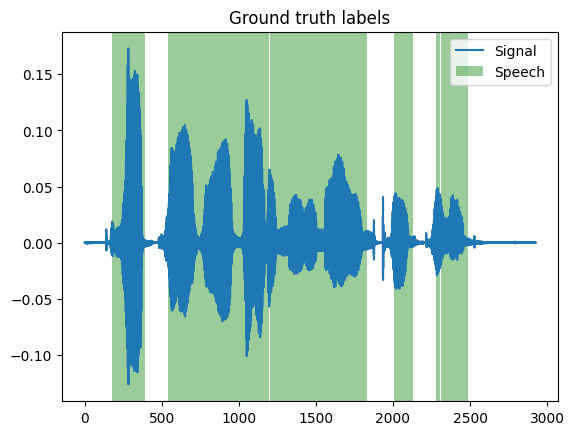

In [ ]:
# Plot signal
# define time axis
Ns = len(data)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * 1000 * Ts  # time axis

shift = 1 - OVERLAP_RATE
frame_length = int(np.floor(FRAME_DURATION * fs / 1000)) # frame length in sample
frame_shift = round(frame_length * shift)# frame shift in sample

figure = plt.Figure(figsize=(10, 7), dpi=85)
plt.plot(t, data)

for i, frame_labeled in enumerate(label_list):
    idx = i * frame_shift
    if (frame_labeled == 1):
        plt.axvspan(xmin= t[idx], xmax=t[idx + frame_length-1], ymin=-1000, ymax=1000, alpha=0.4, zorder=-100, facecolor='g', label='Speech')

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech'])
plt.show()

#Voice Activity Detection

In [ ]:
# Function for reading labels from .TextGrid file
def readLabels(path, sample_rate):
    labeled_list = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate))

        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list

# Function for getting all files in directories and sub-directories with definite extension
def getFiles(path, extension):
    list_paths = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(extension)):
                list_paths.append(os.path.join(root, file))
    return list_paths


In [ ]:
annotation_path = '/content/drive/MyDrive/speechR/Data/Annotation'
annotation_extension = '.TextGrid'
audio_path = '/content/drive/MyDrive/speechR/Data/Audio'
audio_extension = '.wav'

annotation_files = getFiles(path=annotation_path, extension=annotation_extension)
audio_files = getFiles(path=audio_path, extension=audio_extension)
annotation_files = sorted(annotation_files)
audio_files = sorted(audio_files)

print('Number of files:', len(audio_files))

Number of files: 719


In [ ]:
# Set params for model
preemphasis_coef = 0.97
frame_length = 0.025
frame_step = 0.01
window_function = np.hamming
num_nfft = 512
num_features = 32

In [ ]:
# Extraction features for each file
for i in tqdm(range(len(audio_files))):
    sig, sample_rate = librosa.load(audio_files[i])
    markers = readLabels(path=annotation_files[i], sample_rate=sample_rate)

    # Extract features
    features_fbank, feature_energy = python_speech_features.base.fbank(signal=sig, samplerate=sample_rate, winlen=frame_length, winstep=frame_step, nfilt=num_features,
                                                                      nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef, winfunc=window_function)

    # Logfbank and log energy
    features_logfbank = np.log(features_fbank)
    feature_logenergy = np.log(feature_energy)

    # Merge logfbank and log energy
    features = np.hstack((feature_logenergy.reshape(feature_logenergy.shape[0], 1), features_logfbank))

    # Reshape labels for each group of features
    markers_of_frames = python_speech_features.sigproc.framesig(sig=markers, frame_len=frame_length * sample_rate, frame_step=frame_step * sample_rate,
                                                                winfunc=np.ones)

    # For every frame calc label
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])

    # Create massive for stacking features in first step
    if i == 0:
        dataset_tmp = np.zeros((1, num_features + 2))

    # Check indices of features and labels
    restrictive_index = np.min([features.shape[0], marker_per_frame.shape[0]], axis=0)
    features_tmp = features[:restrictive_index]
    marker_per_frame_tmp = marker_per_frame[:restrictive_index]

    # Merge label and frames and all frames in dataset
    dataset_tmp = np.vstack((dataset_tmp, np.hstack((marker_per_frame_tmp.reshape(marker_per_frame_tmp.shape[0], 1), features_tmp))))

# Delete row consisting of zeros
dataset = dataset_tmp[1:]

100%|██████████| 719/719 [07:14<00:00,  1.65it/s]


In [ ]:
# Split dataset into train and test
X = dataset[:, 1:]
y = dataset[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM model
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

(219809, 33) (94205, 33) (219809,) (94205,)


SVC()

In [ ]:
# Predict labels for test data
y_pred = svm_model.predict(X_test)

# Evaluate model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

confusion = metrics.confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.8940820550926172
Precision: 0.8771644780770087
Recall: 0.898358787326191
F1 Score: 0.8876351351351351
Confusion Matrix:
 [[44816  5519]
 [ 4459 39411]]


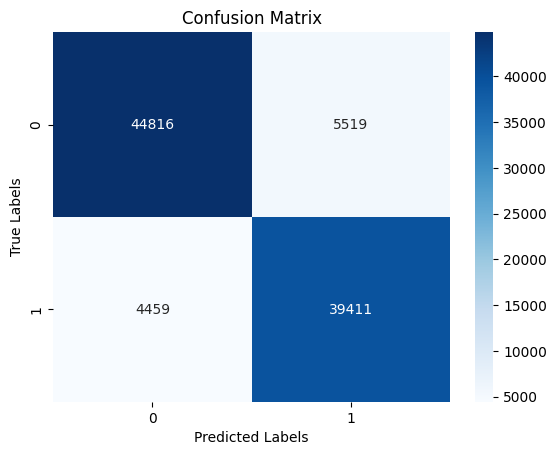

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Validation

In [ ]:
annotation_file = "/content/drive/MyDrive/speechR/Data/Annotation/Female/TMIT/SA1.TextGrid"
audio_file = "/content/drive/MyDrive/speechR/Data/Audio/Female/TMIT/SA1.wav"

In [ ]:
# Load samples:
input_signal, fs = librosa.load(audio_file)

# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract features:
features_fbank_valid, feature_energy_valid  = python_speech_features.base.fbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step,
                                                                                nfilt=num_features, nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef,
                                                                                winfunc=window_function)

# Logfbank and log energy:
features_logfbank_valid = np.log(features_fbank_valid)
feature_logenergy_valid = np.log(feature_energy_valid)

# Merge logfbank and log energy:
features_valid = np.hstack((feature_logenergy_valid.reshape(feature_logenergy_valid.shape[0], 1), features_logfbank_valid))

# Reshape labels for each group of features:
markers_of_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(markers_of_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(markers_of_frames_truth[j], axis=0) > markers_of_frames_truth.shape[0] / 2 else 0
                                   for j in range(markers_of_frames_truth.shape[0])])

# Check indices of features and labels:
restrictive_index = np.min([features_valid.shape[0], markers_of_frames_truth.shape[0]], axis=0)
features_valid_tmp = features_valid[:restrictive_index]
marker_per_frame_truth_tmp = marker_per_frame_truth[:restrictive_index]

In [ ]:
# Split label and features:
X_valid = features_valid_tmp;
y_truth = marker_per_frame_truth_tmp

# Scaling:
X_valid = scaler.transform(X_valid)

In [ ]:
prediction = svm_model.predict(X_valid)

predicted_label = np.zeros(prediction.shape[0])
predicted_proba = np.zeros(prediction.shape[0])
ind = 0
for i in range(prediction.shape[0]):
  if prediction[i] >= 0.5:
      predicted_label[i] = 1
      predicted_proba[i] = prediction[i]
  else:
      predicted_label[i] = 0
      predicted_proba[i] = 1 - prediction[i]


predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label.shape[0]):
    label_timeseries[begin:end] = predicted_label[i]
    begin = begin + shift_step
    end = end + shift_step

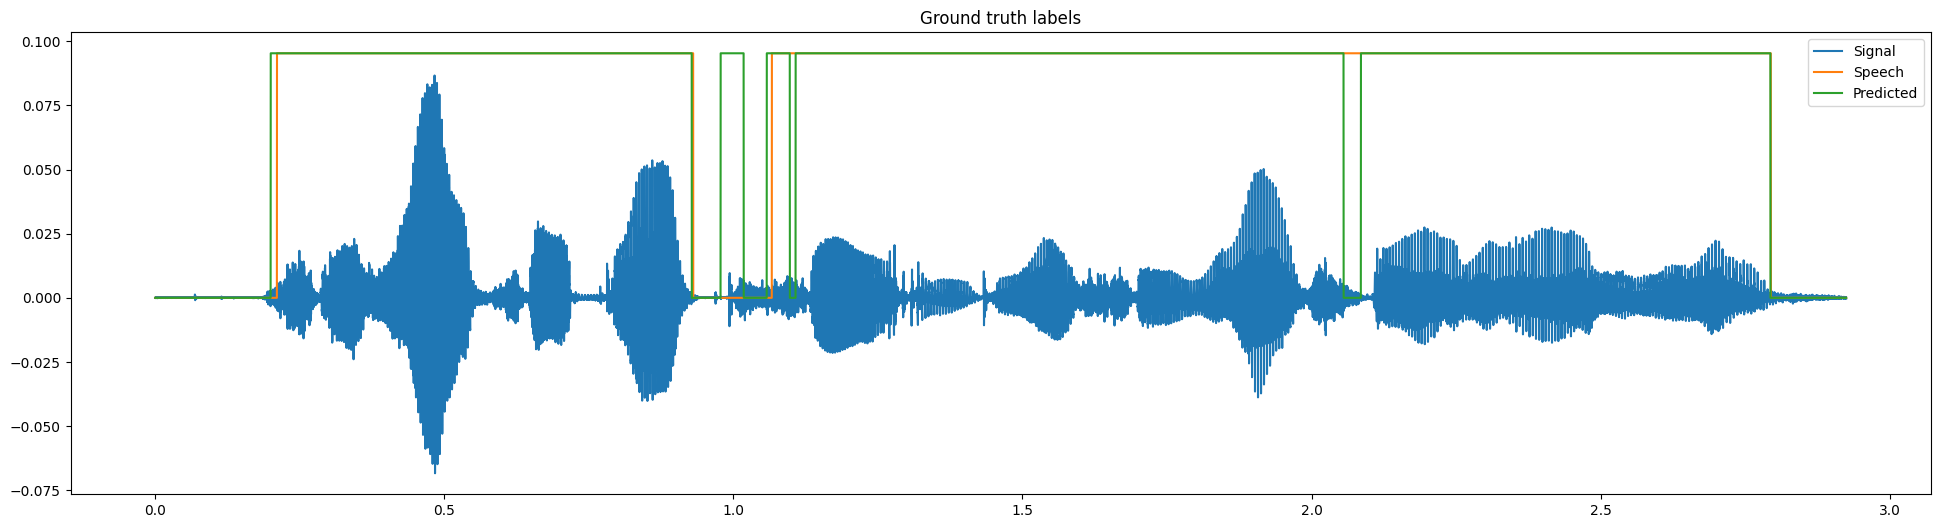

In [ ]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()

In [ ]:
Audio(audio_file)

========================================================================

In [ ]:
annotation_file = "/content/drive/MyDrive/speechR/Data/Annotation/Female/TMIT/SI2220.TextGrid"
audio_file = "/content/drive/MyDrive/speechR/Data/Audio/Female/TMIT/SI2220.wav"

In [ ]:
# Load samples:
input_signal, fs = librosa.load(audio_file)

# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract features:
features_fbank_valid, feature_energy_valid  = python_speech_features.base.fbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step,
                                                                                nfilt=num_features, nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef,
                                                                                winfunc=window_function)

# Logfbank and log energy:
features_logfbank_valid = np.log(features_fbank_valid)
feature_logenergy_valid = np.log(feature_energy_valid)

# Merge logfbank and log energy:
features_valid = np.hstack((feature_logenergy_valid.reshape(feature_logenergy_valid.shape[0], 1), features_logfbank_valid))

# Reshape labels for each group of features:
markers_of_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(markers_of_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(markers_of_frames_truth[j], axis=0) > markers_of_frames_truth.shape[0] / 2 else 0
                                   for j in range(markers_of_frames_truth.shape[0])])

# Check indices of features and labels:
restrictive_index = np.min([features_valid.shape[0], markers_of_frames_truth.shape[0]], axis=0)
features_valid_tmp = features_valid[:restrictive_index]
marker_per_frame_truth_tmp = marker_per_frame_truth[:restrictive_index]

In [ ]:
# Split label and features:
X_valid = features_valid_tmp;
y_truth = marker_per_frame_truth_tmp

# Scaling:
X_valid = scaler.transform(X_valid)

In [ ]:
prediction = svm_model.predict(X_valid)

predicted_label = np.zeros(prediction.shape[0])
predicted_proba = np.zeros(prediction.shape[0])
ind = 0
for i in range(prediction.shape[0]):
  if prediction[i] >= 0.5:
      predicted_label[i] = 1
      predicted_proba[i] = prediction[i]
  else:
      predicted_label[i] = 0
      predicted_proba[i] = 1 - prediction[i]


predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1.

In [ ]:
label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label.shape[0]):
    label_timeseries[begin:end] = predicted_label[i]
    begin = begin + shift_step
    end = end + shift_step

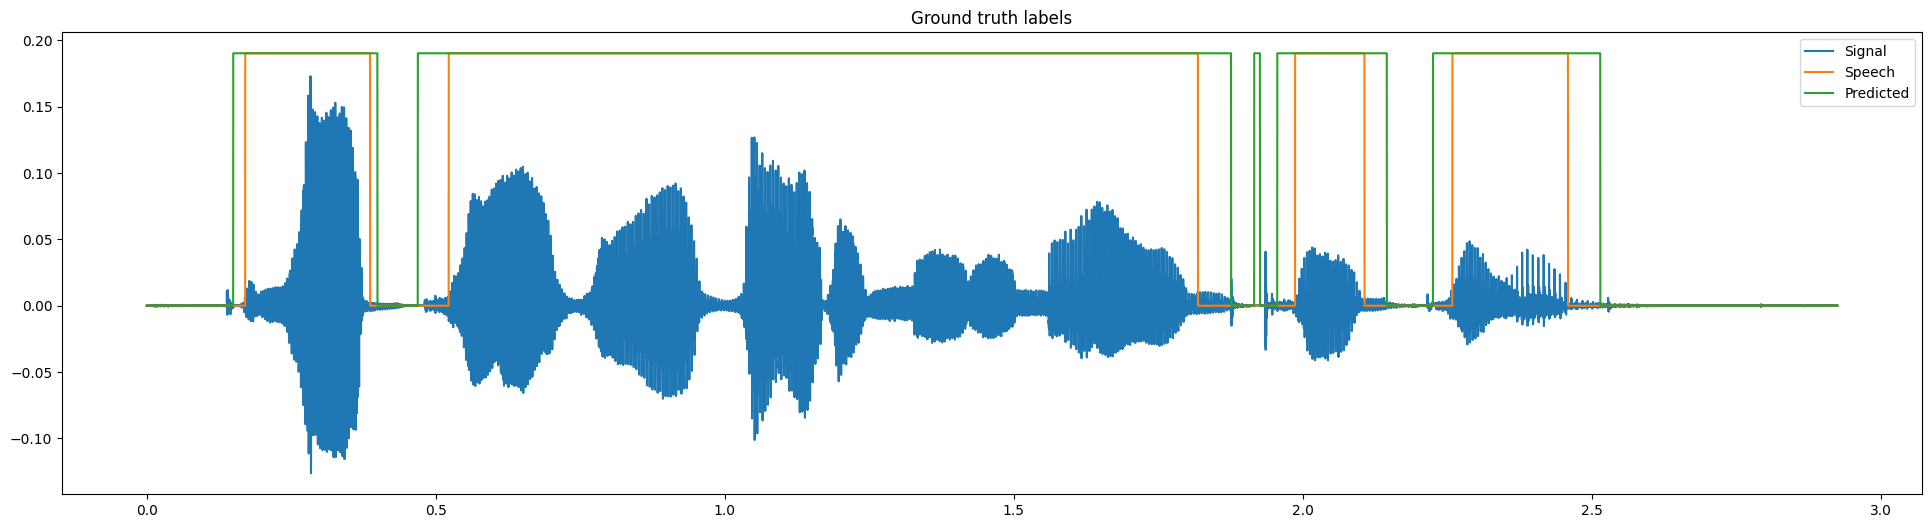

In [ ]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()

In [ ]:
Audio(audio_file)

In [ ]:
annotation_file = "/content/drive/MyDrive/speechR/Data/Annotation/Male/TMIT/SI1060.TextGrid"
audio_file = "/content/drive/MyDrive/speechR/Data/Audio/Male/TMIT/SI1060.wav"

In [ ]:
# Load samples:
input_signal, fs = librosa.load(audio_file)

# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract features:
features_fbank_valid, feature_energy_valid  = python_speech_features.base.fbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step,
                                                                                nfilt=num_features, nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef,
                                                                                winfunc=window_function)

# Logfbank and log energy:
features_logfbank_valid = np.log(features_fbank_valid)
feature_logenergy_valid = np.log(feature_energy_valid)

# Merge logfbank and log energy:
features_valid = np.hstack((feature_logenergy_valid.reshape(feature_logenergy_valid.shape[0], 1), features_logfbank_valid))

# Reshape labels for each group of features:
markers_of_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(markers_of_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(markers_of_frames_truth[j], axis=0) > markers_of_frames_truth.shape[0] / 2 else 0
                                   for j in range(markers_of_frames_truth.shape[0])])

# Check indices of features and labels:
restrictive_index = np.min([features_valid.shape[0], markers_of_frames_truth.shape[0]], axis=0)
features_valid_tmp = features_valid[:restrictive_index]
marker_per_frame_truth_tmp = marker_per_frame_truth[:restrictive_index]

In [ ]:
# Split label and features:
X_valid = features_valid_tmp;
y_truth = marker_per_frame_truth_tmp

# Scaling:
X_valid = scaler.transform(X_valid)

In [ ]:
prediction = svm_model.predict(X_valid)

predicted_label = np.zeros(prediction.shape[0])
predicted_proba = np.zeros(prediction.shape[0])
ind = 0
for i in range(prediction.shape[0]):
  if prediction[i] >= 0.5:
      predicted_label[i] = 1
      predicted_proba[i] = prediction[i]
  else:
      predicted_label[i] = 0
      predicted_proba[i] = 1 - prediction[i]


predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label.shape[0]):
    label_timeseries[begin:end] = predicted_label[i]
    begin = begin + shift_step
    end = end + shift_step

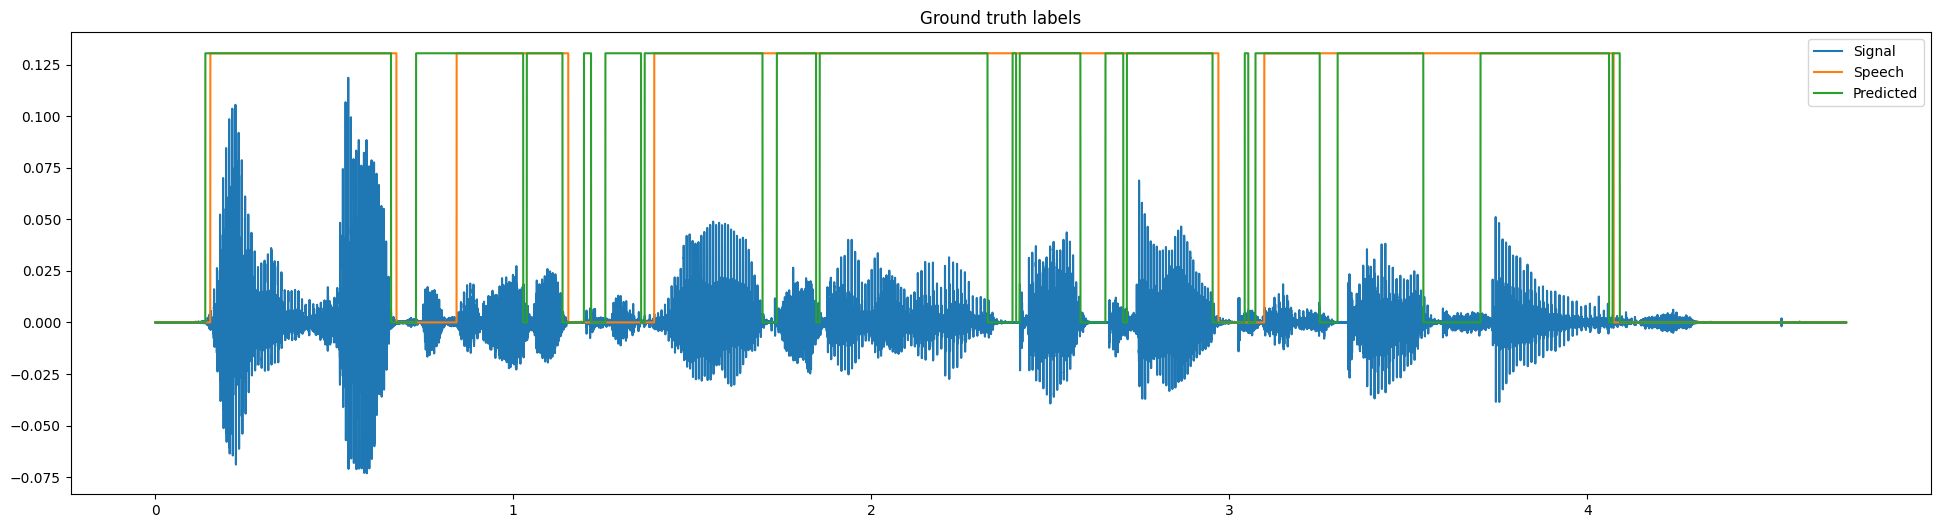

In [ ]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()

In [ ]:
Audio(audio_file)